# Concentrated liquidity

Allows the liquidity providers to concentrate their liquidity in a specfic price range, leading to an increased capital efficiency.

In V3 there are **many price ranges** in one pair and each range has
**finite reserves**. Within that short price ranges, **it works exactly as Uniswap V2**.

A price range limits the movement of the price.
When the price moves to either of the points, the pool becomes depleted: one of the token reserves will be 0. This allows using Uniswap V3 price ranges as limit-orders.

When the current price range gets depleted during a trade the price slips into the next price range. If the next price range doesn't exist, the trade ends up fulfilled partially.


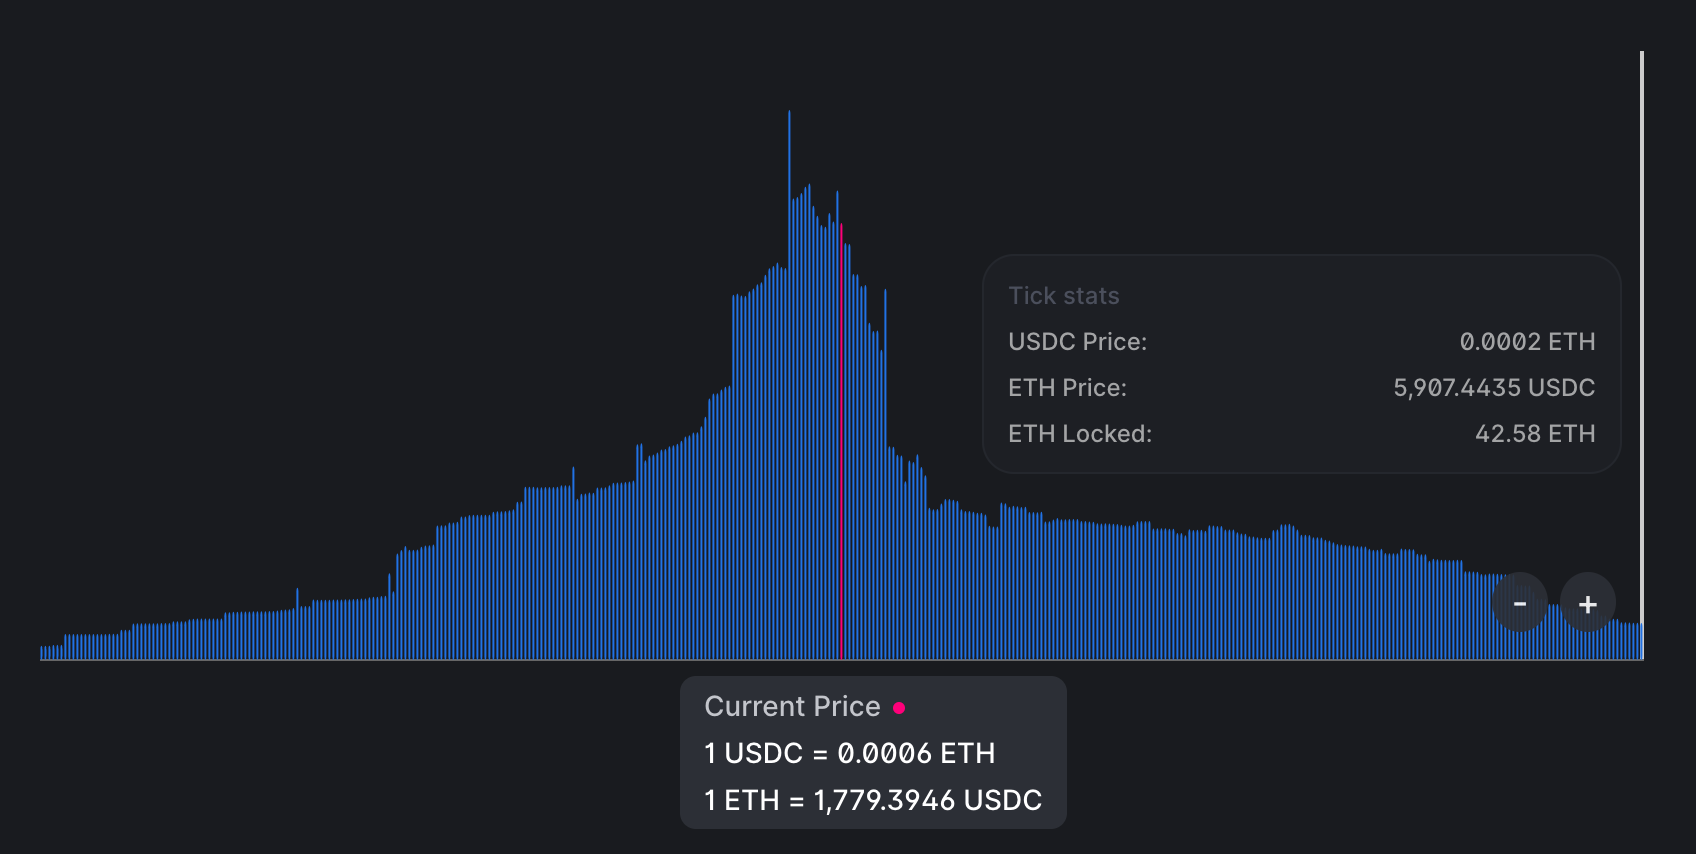

There are 2 new concepts in Uniswap V3:

$$L = \sqrt {xy}$$

$$\sqrt{P} = \sqrt \frac{y}{x}$$

They exists to simplify liquidity management and transitioning between price ranges.


* $X$ and $Y$ - Assets
* $x$ and $y$ - Virtual assets amounts

$L$ - Virtual liquidity amount represented as the geometric mean of $x$ and $y$.

$P = \frac{y}{x}$ - Price of token $X$ in terms of $Y$.

Since token prices in a pool are reciprocals of each other, we can use only one of them in calculations. By convention Uniswap V3 uses $\frac{y}{x}$.

The price of token $Y$ in terms of token $X$ is:
$$\frac{1}{y/x} = \frac{x}{y} \implies \frac{1}{\sqrt P} = \frac{1}{\sqrt {y/x}} = \sqrt \frac{x}{y}$$

We use $\sqrt P$ instead of $P$ because square root calculation is not precise and causes rounding errors.

$$L = \frac{\Delta y}{\Delta \sqrt P}$$

- $p_a$ - Lower bound of a price range
- $p_b$ - Upper bound of a price range

Code tracks square roots like $\sqrt P$, $\sqrt p_a$ and $\sqrt p_b$ for efficiency reasons and to avoid rounding errors.

## Pricing

Output amounts:

* $\Delta y = \Delta \sqrt P L$
* $\Delta x = \Delta \frac{1}{\sqrt P} L$

## Ticks

Infinite price range of V2 is split into shorter price ranges in V3. Each of these shorter price ranges is limited by boundaries - upper and lower points. To track the coordinates of these boundaries Uniswap V3 uses *ticks*.

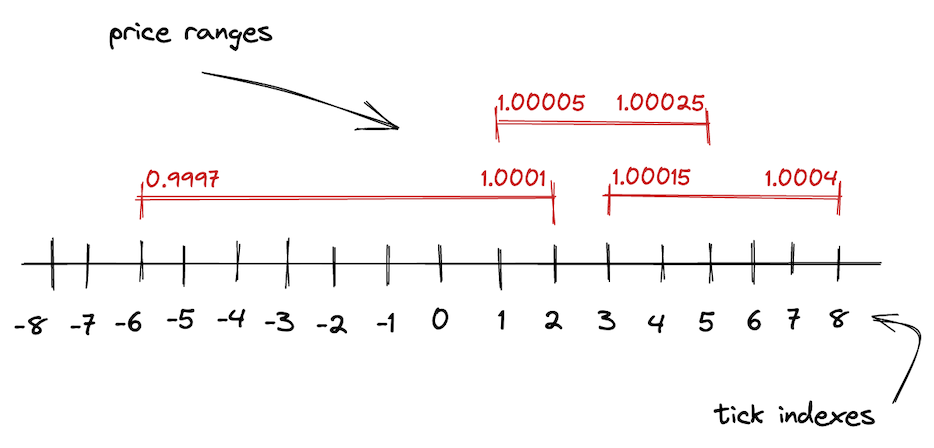

The entire price range is demarkated by evenly distributed discrete ticks.
Each tick as an index and corresponds to a certain price:

$p(i) = 1.0001^i$ - Price at tick $i$

Since Uniswap V3 stores $\sqrt P$ instead of $P$, the formula is in fact:

$$\sqrt{p(i)} = \sqrt{1.0001}^i = 1.0001^{\frac{i}{2}}$$

Ticks are integers that can be positive and negative and, of course, they’re not infinite.
Uniswap V3 stores $\sqrt P$ as a fixed point `Q64.96` number, which is a rational number that uses 64 bits for the integer part and 96 bits for the fractional part. Thus, prices are within the range: $[2^{-128}, 2^{128}]$.


# Calculating liquidity

To add liquidity to the pool contract we need to know:

1. A price range.
2. Amount of liquidity we want to provide, which is the amounts of two tokens. We'll need to transfer these amounts to the pool contract.

## Price range calculation

We need to find 3 ticks:

1. The current tick that corresponds to the current price $P_c$.
2. The lower $P_l$ and 3. upper $P_u$ bounds of the price range we're providing liquidity into.

Lets say $X = ETH$ and $Y = USDC$, the current price is `5000 USDC` for `1 ETH` and we want to provide liquidity at `$4545-$5500`. We know that $\sqrt P = \sqrt{\frac{y}{x}}$. The prices at each tick will be:

$$ \sqrt{P_c} = \sqrt{\frac{5000}{1}} = \sqrt{5000} \approx 70.71 $$
$$ \sqrt{P_l} = \sqrt{\frac{4545}{1}} \approx 67.42 $$
$$ \sqrt{P_u} = \sqrt{\frac{5500}{1}} \approx 74.16 $$

Now can find corresponding ticks. We know that prices and ticks are connected via this formula:

$$\sqrt{p(i)} = 1.0001^{\frac{i}{2}}$$

Thus, we can find tick $i$ via:

$$i = \log_{\sqrt{1.0001}} \sqrt{P(i)}$$

Ticks:
* $i_c = \log_{\sqrt{1.0001}} 70.71 = 85176$
* $i_l = \log_{\sqrt{1.0001}} 67.42 = 84222$
* $i_u = \log_{\sqrt{1.0001}} 74.16 = 86129$

Uniswap V3 uses `Q64.96` numbers to store $\sqrt P$. So we need to convert our prices first. To do this we need to multiply them by the maximum value of the fractional part of `Q64.96`, which is $2^{96}$. We'll get:

$$ \sqrt{P_c} = 5602277097478614198912276234240 $$
$$ \sqrt{P_l} = 5314786713428871004159001755648 $$
$$ \sqrt{P_u} = 5875717789736564987741329162240 $$

In [18]:
import math

min_tick = -887272
max_tick =  887272

q96 = 2**96
eth = 10**18

def price_to_tick(p):
    return math.floor(math.log(p, 1.0001))

def price_to_sqrtp(p):
    return int(math.sqrt(p) * q96)

price_low = 4545
price_cur = 5000
price_upp = 5500

print(f"Price range: ${price_low}-${price_upp}; current price: ${price_cur}")

sqrtp_low = price_to_sqrtp(price_low)
sqrtp_cur = price_to_sqrtp(price_cur)
sqrtp_upp = price_to_sqrtp(price_upp)

print(f"P_c = {sqrtp_cur}");
print(f"P_l = {sqrtp_low}");
print(f"P_u = {sqrtp_upp}");

Price range: $4545-$5500; current price: $5000
P_c = 5602277097478614198912276234240
P_l = 5341294542274603406682713227264
P_u = 5875717789736564987741329162240


# Liquidity amount calculation

We know that:

$$L = \sqrt{xy}$$

However, this formula is for the infinite curve. But we want to put liquidity into a limited price range, which is just a segment of that infinite curve.

